In [2]:
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn.base import clone
from menelaus.concept_drift import LinearFourRates, ADWINAccuracy, DDM, EDDM, STEPD, MD3

In [3]:
import pandas as pd
import numpy as np

In [5]:
df=pd.read_csv('df2.csv')

In [6]:
df.head()

,Unnamed: 0,category,rating,label,count_punct,Number of Words,exclamation_mark,first_person_noun
0,0,1,5.0,0,5,12,1,1
1,1,1,5.0,0,3,16,0,1
2,2,1,5.0,0,2,14,0,2
3,3,1,1.0,0,2,17,0,1
4,4,1,5.0,0,2,18,0,0


In [7]:
df=df.drop(['Unnamed: 0'], axis=1)

In [8]:
df=df.iloc[:,[0,1,3,4,5,6,2]]

In [9]:
df.head()

,category,rating,count_punct,Number of Words,exclamation_mark,first_person_noun,label
0,1,5.0,5,12,1,1,0
1,1,5.0,3,16,0,1,0
2,1,5.0,2,14,0,2,0
3,1,1.0,2,17,0,1,0
4,1,5.0,2,18,0,0,0


In [49]:
training_size = 30324

In [50]:
X_train = df.loc[0:training_size, ['category','rating','count_punct','Number of Words','exclamation_mark','first_person_noun']]
y_train = df.loc[0:training_size, "label"]
X_test = df.loc[training_size:len(df), ['category','rating','count_punct','Number of Words','exclamation_mark','first_person_noun']]
y_true = df.loc[training_size:len(df), "label"]

In [51]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)


LogisticRegression()

In [52]:
acc_orig = np.cumsum(model.predict(X_test) == y_true)
acc_orig = acc_orig / np.arange(1, 1 + len(acc_orig))
print(acc_orig)

30324    0.000000
30325    0.000000
30326    0.333333
30327    0.500000
30328    0.600000
           ...   
40427    0.620447
40428    0.620485
40429    0.620522
40430    0.620560
40431    0.620598
Name: label, Length: 10108, dtype: float64


### ADWIN

In [53]:
adwin = ADWINAccuracy()

# Set up DF to record results.
status = pd.DataFrame(
    columns=["index", "y_true", "y_pred", "adwin mean", "drift_detected"]
)
rec_list = []

In [54]:
for i in range(training_size, len(df)):

    X_test = df.loc[[i], ['category','rating','count_punct','Number of Words','exclamation_mark','first_person_noun']]
    y_pred = int(model.predict(X_test))
    y_true = int(df.loc[[i], "label"])

    adwin.update(y_true, y_pred)
    status.loc[i] = [
        i, y_true, y_pred, adwin.mean(), adwin.drift_state,
    ]

    # If drift is detected, examine the window and retrain.
    if adwin.drift_state == "drift":
        retrain_start = adwin.retraining_recs[0] + training_size
        retrain_end = adwin.retraining_recs[1] + training_size
        rec_list.append([retrain_start, retrain_end])

        # The retraining recommendations produced here correspond to the samples
        # which belong to ADWIN's new, smaller window, after drift is detected.
        # If retraining is not desired, omit the next four lines.
        X_train = df.loc[retrain_start:retrain_end, ['category','rating','count_punct','Number of Words','exclamation_mark','first_person_noun']]
        y_train = df.loc[retrain_start:retrain_end, "label"]
        model = LogisticRegression()
        model.fit(X_train, y_train)
status['original_accuracy'] = acc_orig
status['accuracy'] = np.cumsum(status.y_true == status.y_pred)

status['accuracy'] = status['accuracy'] / np.cumsum(np.repeat(1, status.shape[0]))

/Users/snehalkullolli/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [20]:
print(status)

         index  y_true  y_pred  adwin mean drift_detected  original_accuracy  \
30324  30324.0     0.0     1.0    0.000000            NaN           0.000000   
30325  30325.0     0.0     1.0    0.000000            NaN           0.000000   
30326  30326.0     0.0     0.0    0.333333            NaN           0.333333   
30327  30327.0     0.0     0.0    0.500000            NaN           0.500000   
30328  30328.0     0.0     0.0    0.600000            NaN           0.600000   
...        ...     ...     ...         ...            ...                ...   
40427  40427.0     1.0     1.0    0.524920            NaN           0.620447   
40428  40428.0     0.0     1.0    0.524709            NaN           0.620485   
40429  40429.0     1.0     1.0    0.524900            NaN           0.620522   
40430  40430.0     0.0     1.0    0.524689            NaN           0.620560   
40431  40431.0     1.0     1.0    0.524880            NaN           0.620598   

       accuracy  
30324         0  
303

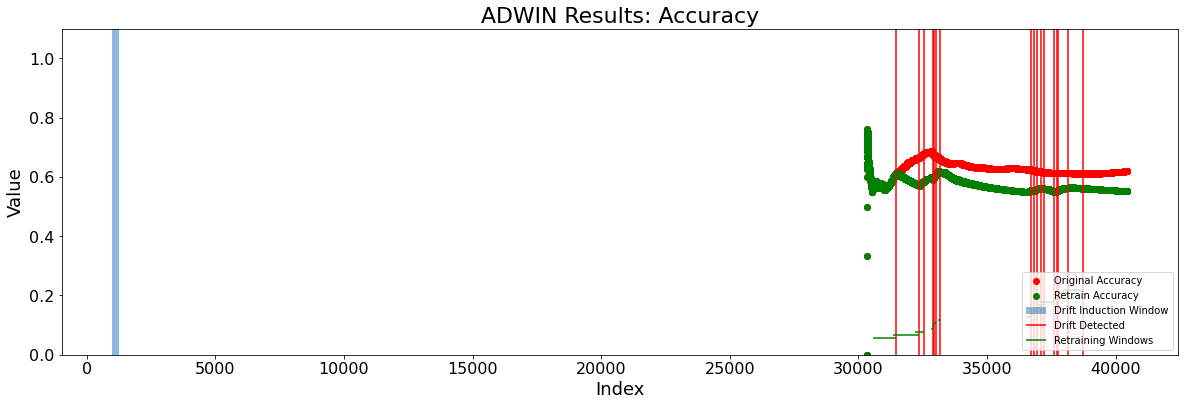

In [39]:
plt.figure(figsize=(20, 6))
plt.scatter("index", "original_accuracy", data=status, label="Original Accuracy", color='red')
plt.scatter("index", "accuracy", data=status, label="Retrain Accuracy", color='green')
plt.grid(False, axis="x")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("ADWIN Results: Accuracy", fontsize=22)
plt.ylabel("Value", fontsize=18)
plt.xlabel("Index", fontsize=18)
ylims = [0, 1.1]
plt.ylim(ylims)

plt.axvspan(1000, 1250, alpha=0.5, label="Drift Induction Window")

# Draw red lines that indicate where drift was detected
plt.vlines(
    x=status.loc[status["drift_detected"] == "drift"]["index"],
    ymin=ylims[0],
    ymax=ylims[1],
    label="Drift Detected",
    color="red",
)

# Create a list of lines that indicate the retraining windows.
# Space them evenly, vertically.
rec_list = pd.DataFrame(rec_list)
rec_list["y_val"] = np.linspace(
    start=0.05 * (ylims[1] - ylims[0]) + ylims[0],
    stop=0.2 * ylims[1],
    num=len(rec_list),
)

# Draw green lines that indicate where retraining occurred
plt.hlines(
    y=rec_list["y_val"],
    xmin=rec_list[0],
    xmax=rec_list[1],
    color="green",
    label="Retraining Windows",
)

plt.legend(loc='lower right')
plt.show()
# plt.savefig("example_ADWINAccuracy.png")


### DDM

In [37]:
X_train = df.loc[0:training_size, ['category','rating','count_punct','Number of Words','exclamation_mark','first_person_noun']]
y_train = df.loc[0:training_size, "label"]
X_test = df.loc[training_size:len(df), ['category','rating','count_punct','Number of Words','exclamation_mark','first_person_noun']]
y_true = df.loc[training_size:len(df), "label"]

In [38]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)
acc_orig = np.cumsum(model.predict(X_test) == y_true)
acc_orig = acc_orig / np.arange(1, 1 + len(acc_orig))
print(acc_orig)


30324    0.000000
30325    0.000000
30326    0.333333
30327    0.500000
30328    0.600000
           ...   
40427    0.620447
40428    0.620485
40429    0.620522
40430    0.620560
40431    0.620598
Name: label, Length: 10108, dtype: float64


In [39]:
ddm = DDM(n_threshold=100, warning_scale=7, drift_scale=10)

# setup DF to store results
status = pd.DataFrame(columns=["index", "y_true", "y_pred", "drift_detected"])
rec_list = []

In [40]:
for i in range(training_size, len(df)):

    X_test = df.loc[[i], ['category','rating','count_punct','Number of Words','exclamation_mark','first_person_noun']]
    y_pred = int(model.predict(X_test))
    y_true = int(df.loc[[i], "label"])

    ddm.update(y_true, y_pred)
    status.loc[i] = [i, y_true, y_pred, ddm.drift_state]

    # If drift is detected, examine the window and retrain.
    if ddm.drift_state == "drift":
        print("Detected at"+str(i))
        retrain_start = ddm.retraining_recs[0] +training_size
        retrain_end = ddm.retraining_recs[1] + training_size
        if (
            retrain_start == retrain_end
        ):  # minimum retraining window in case of sudden drift
            retrain_start = max(0, retrain_start - 300)
        rec_list.append([retrain_start, retrain_end])

        # If retraining is not desired, omit the next four lines.
        X_train = df.loc[retrain_start:retrain_end, ['category','rating','count_punct','Number of Words','exclamation_mark','first_person_noun']]
        y_train = df.loc[retrain_start:retrain_end, "label"]
        model = LogisticRegression()
        model.fit(X_train, y_train)

status['original_accuracy'] = acc_orig
status['accuracy'] = np.cumsum(status.y_true == status.y_pred)

status['accuracy'] = status['accuracy'] / np.cumsum(np.repeat(1, status.shape[0]))

Detected at34426
Detected at36702


In [24]:
print(status)

         index  y_true  y_pred drift_detected  original_accuracy  accuracy
30324  30324.0     0.0     1.0            NaN           0.000000  0.000000
30325  30325.0     0.0     1.0            NaN           0.000000  0.000000
30326  30326.0     0.0     0.0            NaN           0.333333  0.333333
30327  30327.0     0.0     0.0            NaN           0.500000  0.500000
30328  30328.0     0.0     0.0            NaN           0.600000  0.600000
...        ...     ...     ...            ...                ...       ...
40427  40427.0     1.0     0.0            NaN           0.620447  0.600059
40428  40428.0     0.0     0.0            NaN           0.620485  0.600099
40429  40429.0     1.0     1.0            NaN           0.620522  0.600139
40430  40430.0     0.0     0.0            NaN           0.620560  0.600178
40431  40431.0     1.0     1.0            NaN           0.620598  0.600218

[10108 rows x 6 columns]


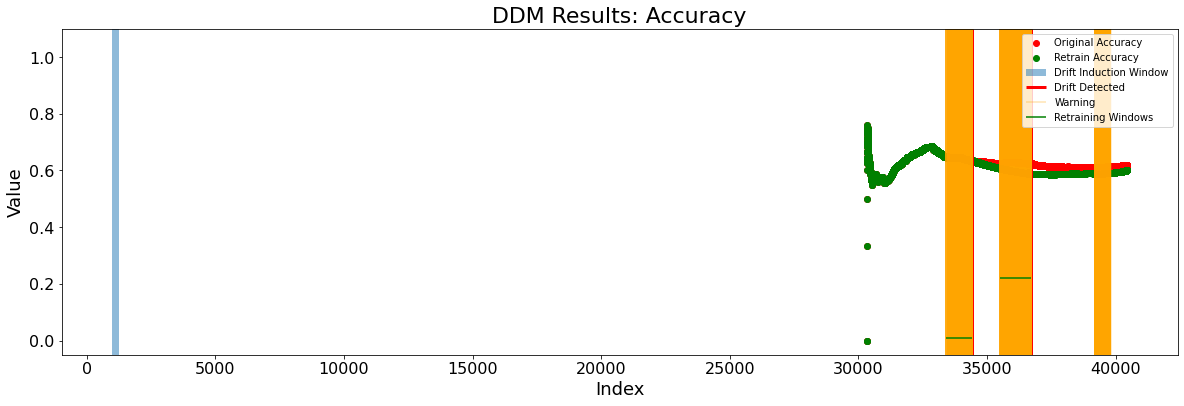

In [45]:
plt.figure(figsize=(20, 6))
plt.scatter("index", "original_accuracy", data=status, label="Original Accuracy", color='red')
plt.scatter("index", "accuracy", data=status, label="Retrain Accuracy", color='green')
plt.grid(False, axis="x")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("DDM Results: Accuracy", fontsize=22)
plt.ylabel("Value", fontsize=18)
plt.xlabel("Index", fontsize=18)
ylims = [-0.05, 1.1]
plt.ylim(ylims)

plt.axvspan(1000, 1250, alpha=0.5, label="Drift Induction Window")

# Draw red lines that indicate where drift was detected
plt.vlines(
    x=status.loc[status["drift_detected"] == "drift"]["index"],
    ymin=ylims[0],
    ymax=ylims[1],
    label="Drift Detected",
    color="red",
    linewidth=3,
)

# Draw orange lines that indicate where warnings of drift were provided
plt.vlines(
    x=status.loc[status["drift_detected"] == "warning"]["index"],
    ymin=ylims[0],
    ymax=ylims[1],
    label="Warning",
    color="orange",
    alpha=0.3,
)

# Create a list of lines that indicate the retraining windows.
# Space them evenly, vertically.
rec_list = pd.DataFrame(rec_list)
rec_list["y_val"] = np.linspace(
    start=0.05 * (ylims[1] - ylims[0]) + ylims[0],
    stop=0.2 * ylims[1],
    num=len(rec_list),
)

# Draw green lines that indicate where retraining occurred
plt.hlines(
    y=rec_list["y_val"],
    xmin=rec_list[0],
    xmax=rec_list[1],
    color="green",
    label="Retraining Windows",
)

plt.legend()
plt.show()
# plt.savefig("example_DDM.png")

### EDDM

In [42]:
X_train = df.loc[0:training_size, ['category','rating','count_punct','Number of Words','exclamation_mark','first_person_noun']]
y_train = df.loc[0:training_size, "label"]
X_test = df.loc[training_size:len(df), ['category','rating','count_punct','Number of Words','exclamation_mark','first_person_noun']]
y_true = df.loc[training_size:len(df), "label"]

In [43]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)
acc_orig = np.cumsum(model.predict(X_test) == y_true)
acc_orig = acc_orig / np.arange(1, 1 + len(acc_orig))
print(acc_orig)

30324    0.000000
30325    0.000000
30326    0.333333
30327    0.500000
30328    0.600000
           ...   
40427    0.620447
40428    0.620485
40429    0.620522
40430    0.620560
40431    0.620598
Name: label, Length: 10108, dtype: float64


In [44]:
eddm = EDDM(n_threshold=30, warning_thresh=0.7, drift_thresh=0.5)

# setup DF to store results
status = pd.DataFrame(columns=["index", "y_true", "y_pred", "drift_detected"])
rec_list = []

In [45]:
for i in range(training_size, len(df)):

    X_test = df.loc[[i], ['category','rating','count_punct','Number of Words','exclamation_mark','first_person_noun']]
    y_pred = int(model.predict(X_test))
    y_true = int(df.loc[[i], "label"])

    eddm.update(y_true, y_pred)
    status.loc[i] = [i, y_true, y_pred, eddm.drift_state]

    # If drift is detected, examine the window and retrain.
    

In [46]:
if eddm.drift_state == "drift":
        print("Detected at"+str(i))
        retrain_start = eddm.retraining_recs[0] + training_size
        retrain_end = eddm.retraining_recs[1] + training_size
        if (
            retrain_start == retrain_end
        ):  # minimum retraining window in case of sudden drift
            retrain_start = max(0, retrain_start - 300)
        rec_list.append([retrain_start, retrain_end])

        # If retraining is not desired, omit the next four lines.
        X_train = df.loc[retrain_start:retrain_end, ['category','rating','count_punct','Number of Words','exclamation_mark','first_person_noun']]
        y_train = df.loc[retrain_start:retrain_end, "label"]
        model = LogisticRegression()
        model.fit(X_train, y_train)

In [47]:
status['original_accuracy'] = acc_orig
status['accuracy'] = np.cumsum(status.y_true == status.y_pred)

status['accuracy'] = status['accuracy'] / np.cumsum(np.repeat(1, status.shape[0]))

In [32]:
print(status)

         index  y_true  y_pred drift_detected  original_accuracy  accuracy
30324  30324.0     0.0     1.0            NaN           0.000000  0.000000
30325  30325.0     0.0     1.0            NaN           0.000000  0.000000
30326  30326.0     0.0     0.0            NaN           0.333333  0.333333
30327  30327.0     0.0     0.0            NaN           0.500000  0.500000
30328  30328.0     0.0     0.0            NaN           0.600000  0.600000
...        ...     ...     ...            ...                ...       ...
40427  40427.0     1.0     0.0        warning           0.620447  0.620447
40428  40428.0     0.0     0.0        warning           0.620485  0.620485
40429  40429.0     1.0     1.0        warning           0.620522  0.620522
40430  40430.0     0.0     0.0        warning           0.620560  0.620560
40431  40431.0     1.0     1.0        warning           0.620598  0.620598

[10108 rows x 6 columns]


KeyError: 0

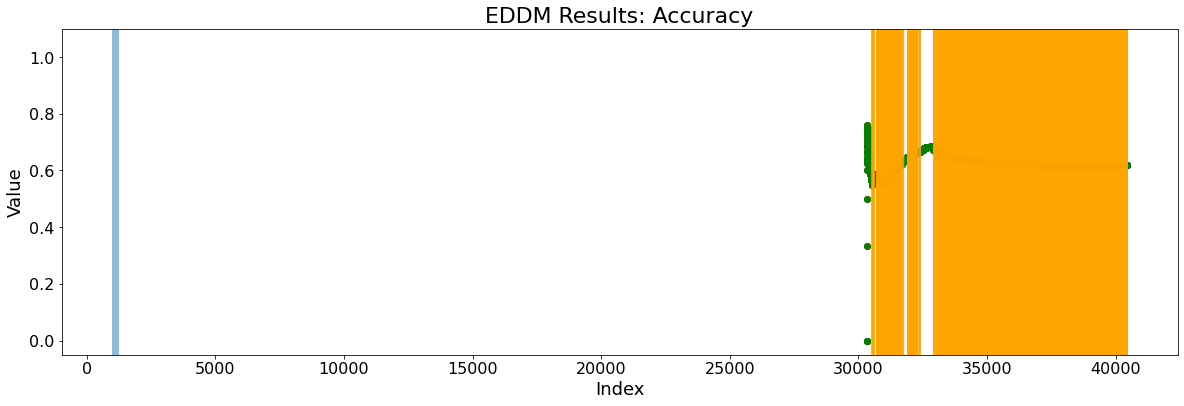

In [53]:
plt.figure(figsize=(20, 6))
plt.scatter("index", "original_accuracy", data=status, label="Original Accuracy", color='red')
plt.scatter("index", "accuracy", data=status, label="Retrain Accuracy", color='green')
plt.grid(False, axis="x")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("EDDM Results: Accuracy", fontsize=22)
plt.ylabel("Value", fontsize=18)
plt.xlabel("Index", fontsize=18)
ylims = [-0.05, 1.1]
plt.ylim(ylims)

plt.axvspan(1000, 1250, alpha=0.5, label="Drift Induction Window")

# Draw orange lines that indicate where warnings of drift were provided
plt.vlines(
    x=status.loc[status["drift_detected"] == "warning"]["index"],
    ymin=ylims[0],
    ymax=ylims[1],
    label="Warning",
    color="orange",
    alpha=0.3,
)

# Draw red lines that indicate where drift was detected
plt.vlines(
    x=status.loc[status["drift_detected"] == "drift"]["index"],
    ymin=ylims[0],
    ymax=ylims[1],
    label="Drift Detected",
    color="red",
)
# Create a list of lines that indicate the retraining windows.
# Space them evenly, vertically.
rec_list = pd.DataFrame(rec_list)
rec_list["y_val"] = np.linspace(
    start=0.05 * (ylims[1] - ylims[0]) + ylims[0],
    stop=0.2 * ylims[1],
    num=len(rec_list),
)

# Draw green lines that indicate where retraining occurred
plt.hlines(
    y=rec_list["y_val"],
    xmin=rec_list[0],
    xmax=rec_list[1],
    color="green",
    label="Retraining Windows",
    alpha=0.3,
)

plt.legend()
plt.show()
# plt.savefig("example_EDDM.png")